# Are there CopyCatch-alike clusters in the Dagster.io detector output?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fake = pd.read_csv("data/copycatch_test_stargazers_fake.csv")
real = pd.read_csv("data/copycatch_test_stargazers_real.csv")
fake.starred_at = pd.to_datetime(fake.starred_at).dt.tz_localize(None)
real.starred_at = pd.to_datetime(real.starred_at).dt.tz_localize(None)
fake.head()

,actor,repo,starred_at
0,z5,pop-os/gtk-theme,2022-01-14 10:45:33
1,z5,sjsdfg/effective-java-3rd-chinese,2020-03-01 11:46:46
2,z5,SergioBenitez/Rocket,2019-08-11 07:10:16
3,z5,xuxueli/xxl-job,2020-08-15 11:12:14
4,z5,deadc0de6/dotdrop,2019-08-14 06:06:40


## Overall Trend

We have evidence to confirm our hypothesis that on average, suspected fake accounts are more bursty. They on average star less repositories, but in each month, they on average star more. Maybe most fake accounts are still throw-away accounts that are discarded after starring a few repos.

### Distribution of Number of Repos Starred per Actor

,count,mean,std,min,25%,50%,75%,max
real,86674.0,146.337529,656.008359,1.0,12.0,43.0,131.0,121122.0
fake,86674.0,20.796917,48.667178,1.0,1.0,5.0,17.0,1256.0


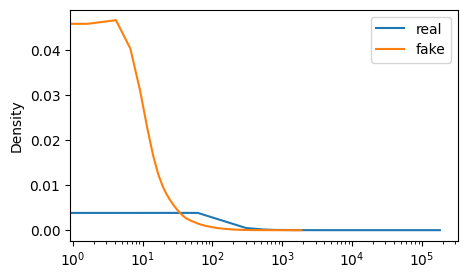

In [3]:
real_repos = real.groupby("actor").count().repo
fake_repos = fake.groupby("actor").count().repo

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
real_repos.plot.density(ax=ax, label="real")
fake_repos.plot.density(ax=ax, label="fake")
ax.set_xscale("log")
ax.legend()

pd.DataFrame({"real": real_repos.describe(), "fake": fake_repos.describe()}).T

### Distribution of Actor Active Range (in Days)

,count,mean,std,min,25%,50%,75%,max
real,86674.0,1021.743418,633.007805,1.0,440.0,1107.0,1647.0,1828.0
fake,86674.0,314.245114,506.843539,1.0,1.0,7.0,439.0,1828.0


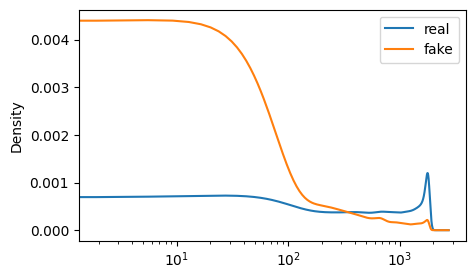

In [4]:
real_ranges = real.groupby("actor").starred_at.pipe(lambda x: x.max() - x.min()).dt.days + 1
fake_ranges = fake.groupby("actor").starred_at.pipe(lambda x: x.max() - x.min()).dt.days + 1

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
real_ranges.plot.density(ax=ax, label="real")
fake_ranges.plot.density(ax=ax, label="fake")
ax.set_xscale("log")
ax.legend()

pd.DataFrame({"real": real_ranges.describe(), "fake": fake_ranges.describe()}).T

### Distribution of Actor Stars per Day

,count,mean,std,min,25%,50%,75%,max
real,86674.0,0.552025,10.899984,0.001206,0.025505,0.065685,0.18847,2086.0
fake,86674.0,2.150085,6.578276,0.001149,0.043243,1.000000,1.00000,574.0


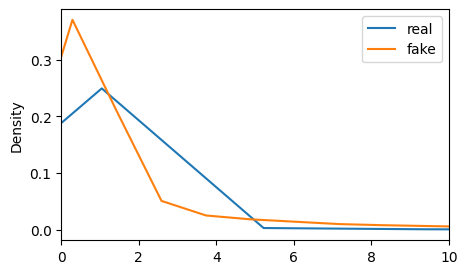

In [5]:
real_stars_per_day = real_repos / real_ranges
fake_stars_per_day = fake_repos / fake_ranges

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
real_stars_per_day.plot.density(ax=ax, label="real")
fake_stars_per_day.plot.density(ax=ax, label="fake")
ax.set_xlim(0, 10)
ax.legend()

pd.DataFrame({"real": real_stars_per_day.describe(), "fake": fake_stars_per_day.describe()}).T

### Time Series by Month

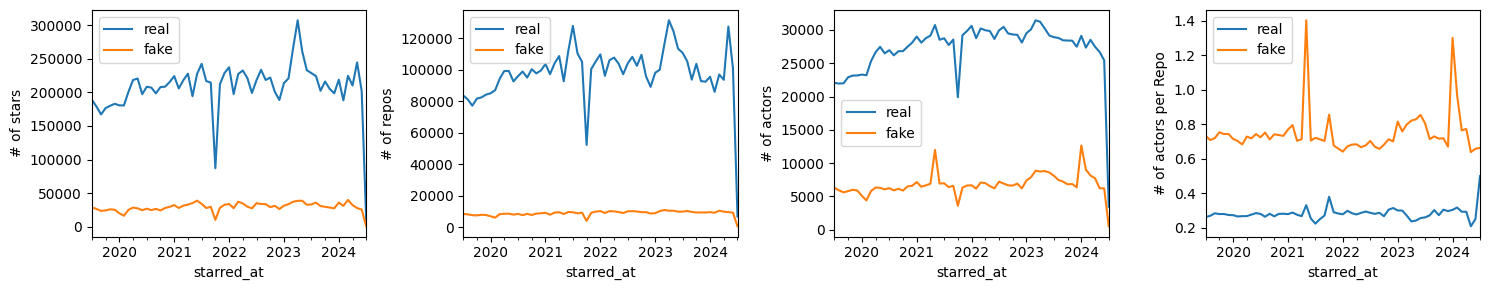

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

fake_by_month = fake.groupby(fake.starred_at.dt.to_period("M"))
real_by_month = real.groupby(real.starred_at.dt.to_period("M"))

real_by_month.size().plot(label="real", ax=axes[0])
fake_by_month.size().plot(label="fake", ax=axes[0])
axes[0].set_ylabel("# of stars")
axes[0].legend()

real_by_month.repo.nunique().plot(label="real", ax=axes[1])
fake_by_month.repo.nunique().plot(label="fake", ax=axes[1])
axes[1].set_ylabel("# of repos")
axes[1].legend()

real_by_month.actor.nunique().plot(label="real", ax=axes[2])
fake_by_month.actor.nunique().plot(label="fake", ax=axes[2])
axes[2].set_ylabel("# of actors")
axes[2].legend()

(real_by_month.actor.nunique() / real_by_month.repo.nunique()).plot(label="real", ax=axes[3])
(fake_by_month.actor.nunique() / fake_by_month.repo.nunique()).plot(label="fake", ax=axes[3])
axes[3].set_ylabel("# of actors per Repo")
axes[3].legend()

fig.tight_layout()

## Per-Repo Case Studies